In [26]:
import pandas as pd
from plotting import plot
from time_mean import mean_in_time
from pandas.plotting import register_matplotlib_converters
import numpy as np
from app_mask import apply_mask
from cross_corr import crosscorr
import matplotlib.pyplot as plt
from scipy.stats import pearsonr 
import seaborn as sns
import matplotlib.dates as mdates
import seaborn as sns
sns.set(rc={'figure.figsize': (15, 8)})

In [27]:
inflation= pd.read_csv('data/inflation.csv', sep=",")
inflation_since_1996=apply_mask(inflation,'1996-01-20','2019-12-30')
inflation_since_2003=apply_mask(inflation,'2003-01-20','2019-12-30')
monetary_base= pd.read_csv('data/monetary_base.csv', sep=",",thousands='.',dtype={'Monetary Base':np.int32})
monetary_base_monthly_mean=mean_in_time(monetary_base,"1M")
yearly_monetary_base=mean_in_time(monetary_base,"1Y")
yearly_monetary_base_since_2003=apply_mask(yearly_monetary_base,'2003-01-20','2019-12-30')


[Text(0.5, 1.0, 'Inflation over time, Argentina')]

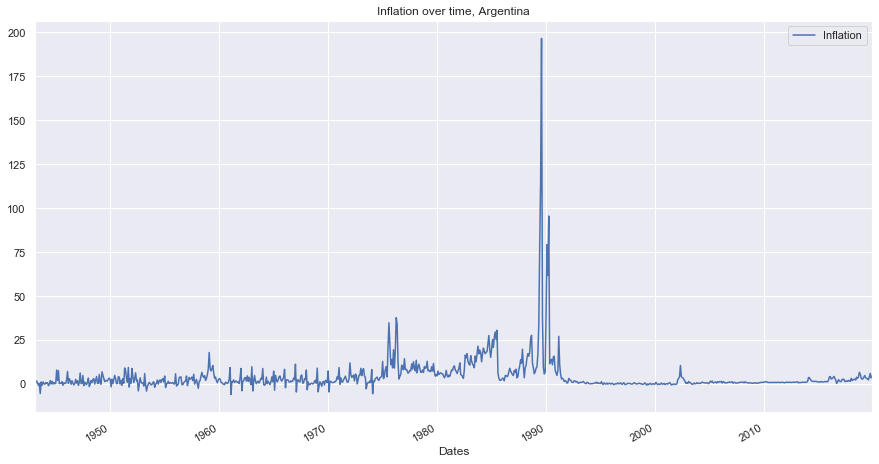

In [28]:
inflation.set_index('Dates', inplace=True)
ax1=inflation.plot()
ax1.set(title='Inflation over time, Argentina')

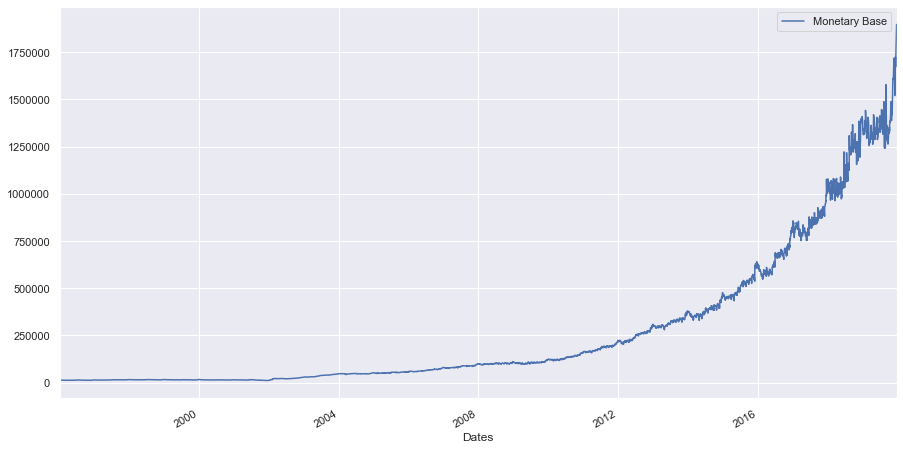

In [29]:
monetary_base.set_index('Dates', inplace=True)
monetary_base.plot()

[Text(0.5, 1.0, 'Monthly monetary base over time')]

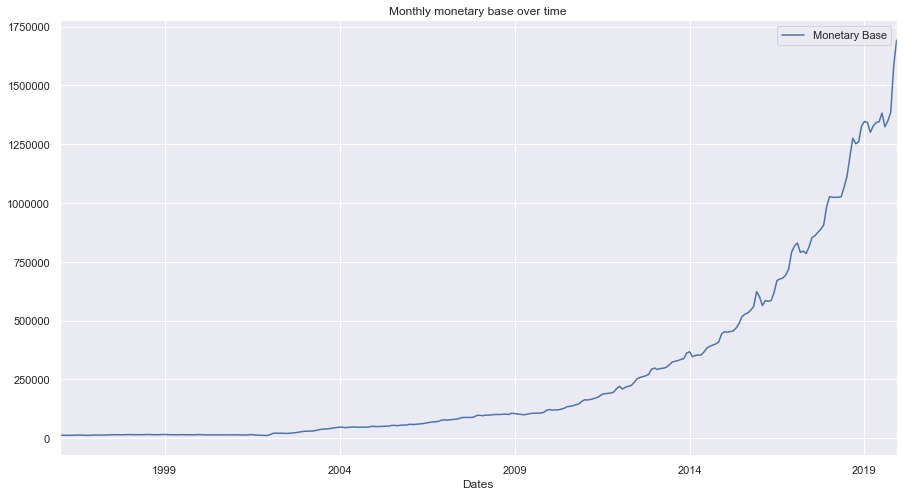

In [30]:
monetary_base_monthly_mean.set_index('Dates', inplace=True)
ax = monetary_base_monthly_mean.plot()
ax.set(title='Monthly monetary base over time')

In [31]:
change_monetary_base_monthly_mean=monetary_base_monthly_mean.copy()
change_monetary_base_monthly_mean["Monetary Base"]=change_monetary_base_monthly_mean["Monetary Base"].pct_change()*100
change_monetary_base_monthly_mean=change_monetary_base_monthly_mean.rename(columns={"Monetary Base":"Change Monetary Base"})



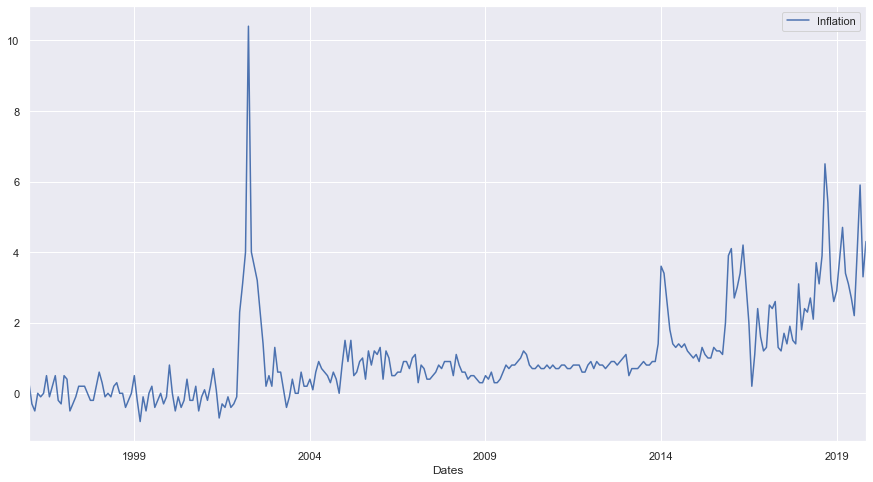

In [32]:
inflation_since_1996.set_index('Dates', inplace=True)
inflation_since_1996.plot()

Pearson Coefficient

In [33]:
pearsonr(change_monetary_base_monthly_mean['Change Monetary Base'][1:-1],inflation_since_1996['Inflation'][1:])

(0.15236211442722652, 0.009866427960875739)

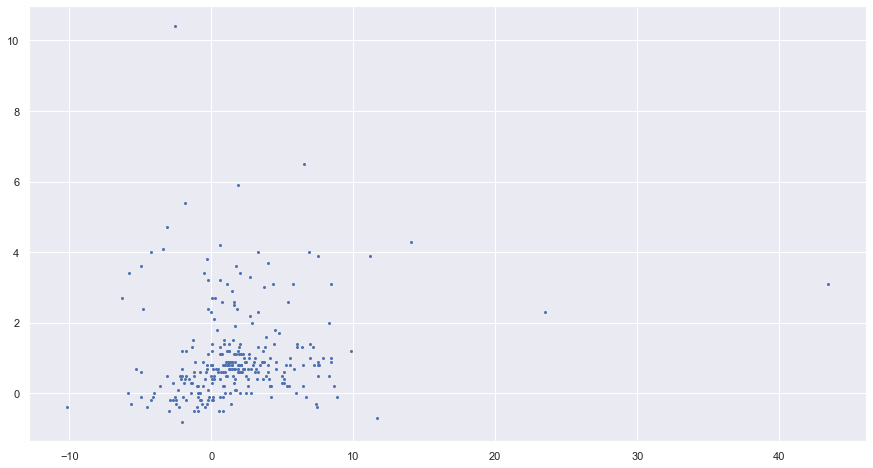

In [34]:
plt.plot(change_monetary_base_monthly_mean['Change Monetary Base'].values[:-1],inflation_since_1996['Inflation'].values,'o',markersize=2)

Pearson with window

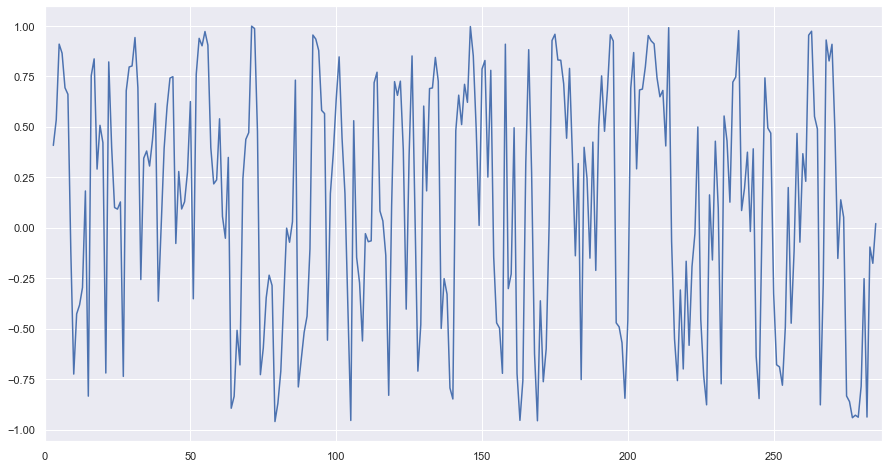

In [35]:
window=4 #in months
change_monetary_base_values=change_monetary_base_monthly_mean['Change Monetary Base'].reset_index().drop(['Dates'],axis=1)
inflation_values=inflation_since_1996['Inflation'].reset_index().drop(['Dates'],axis=1)
rolling_r=change_monetary_base_values['Change Monetary Base'].rolling(window=window,center=True).corr(inflation_values['Inflation'])
rolling_r.plot()

shifted pearson

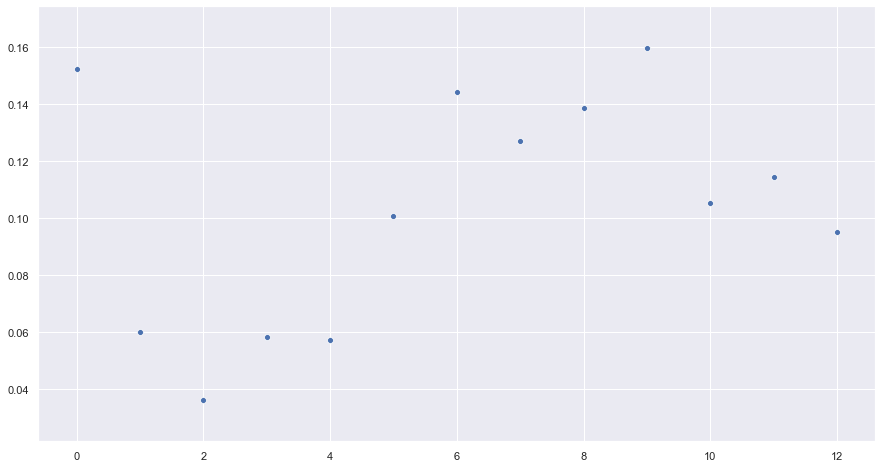

In [36]:
rs = [crosscorr(change_monetary_base_values,inflation_values, lag) for lag in np.arange(0,13,1)]
sns.scatterplot(np.arange(0,13,1),rs)

Analysing the pearson index with a lag, the highest value is obtained with a lag of 10 months

# Working Annually

In [37]:
yearly_inflation_since_1996=inflation_since_1996.copy().resample('Y').sum()

In [38]:
yearly_change_monetary_base=yearly_monetary_base.copy()
yearly_change_monetary_base['Monetary Base']=yearly_monetary_base["Monetary Base"].pct_change()*100

In [39]:
data= pd.DataFrame(yearly_inflation_since_1996['Inflation'])
data=data.merge(yearly_change_monetary_base["Monetary Base"],on=data.index)
data=data.rename(columns={"key_0":"Dates"}).set_index('Dates')
data.dropna()

,Inflation,Monetary Base
Dates,,
1997-12-31,0.4,12.404216
1998-12-31,0.6,7.054448
1999-12-31,-1.9,-2.647394
2000-12-31,-0.8,-3.566412
2001-12-31,-1.4,-5.368243
2002-12-31,35.2,60.979362
2003-12-31,3.5,69.581882
2004-12-31,5.9,28.824240
2005-12-31,11.6,11.933062


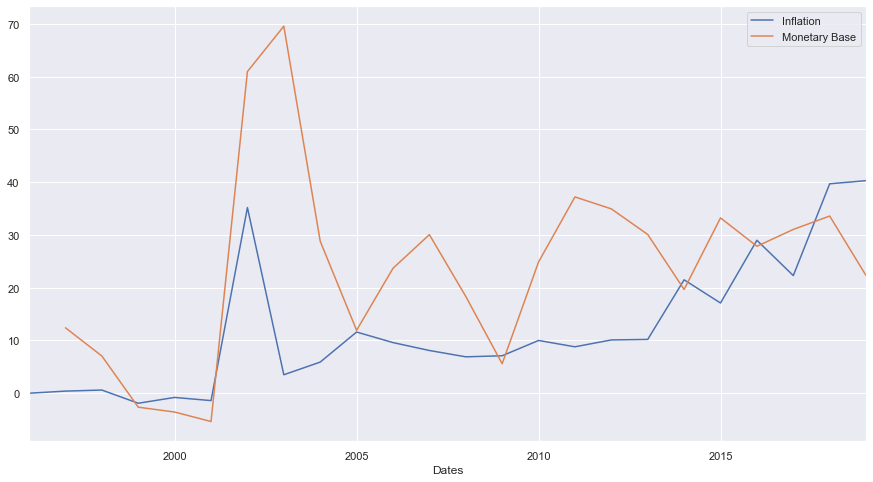

In [40]:
data.plot()

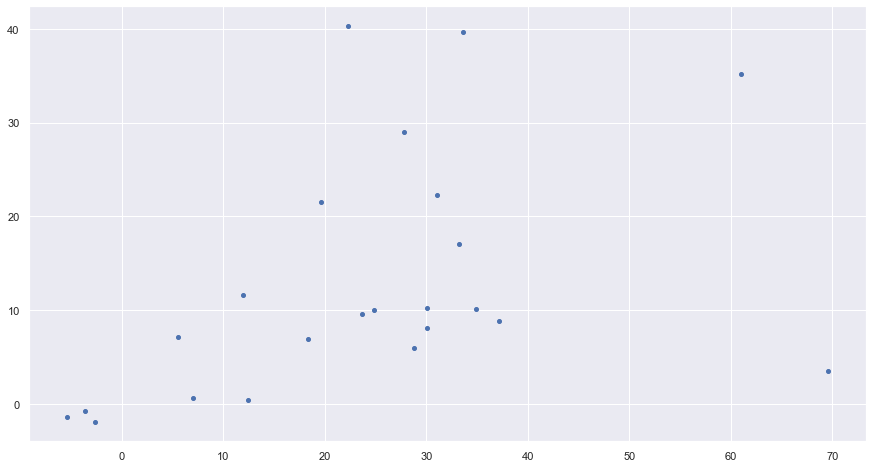

In [41]:
plt.plot(yearly_change_monetary_base['Monetary Base'].values[1:],yearly_inflation_since_1996['Inflation'].values[1:],'o',markersize=4)

[Text(0, 0.5, 'Pearson coefficient'),
 Text(0.5, 0, 'lag in years'),
 Text(0.5, 1.0, 'Pearson coefficient shifting monetary base, since 1996')]

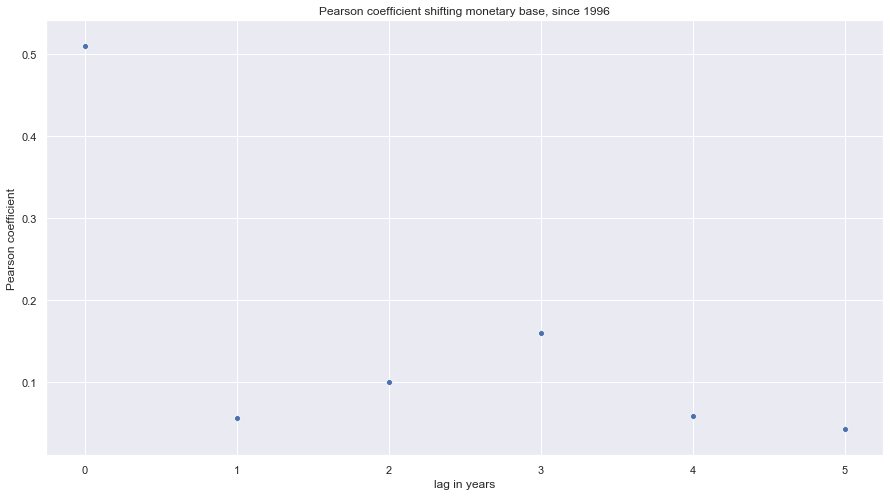

In [42]:
rs = [crosscorr(yearly_inflation_since_1996[:-1].reset_index().drop(['Dates'],axis=1),yearly_change_monetary_base[1:].drop(['Dates'],axis=1), lag) for lag in np.arange(0,6,1)]
ax = sns.scatterplot(np.arange(0,6,1),rs)
ax.set(xlabel='lag in years', ylabel='Pearson coefficient',title='Pearson coefficient shifting monetary base, since 1996')

If we consider the data after the 2001, the point at 0 lag has a lower pearson coefficient than with 3 moths of lag

In [43]:
yearly_change_monetary_base_since_2003=yearly_monetary_base_since_2003.copy()
yearly_change_monetary_base_since_2003['Monetary Base']=yearly_monetary_base_since_2003["Monetary Base"].pct_change()*100
inflation_since_2003.set_index('Dates', inplace=True)
yearly_inflation_since_2003=inflation_since_2003.copy().resample('Y').sum()

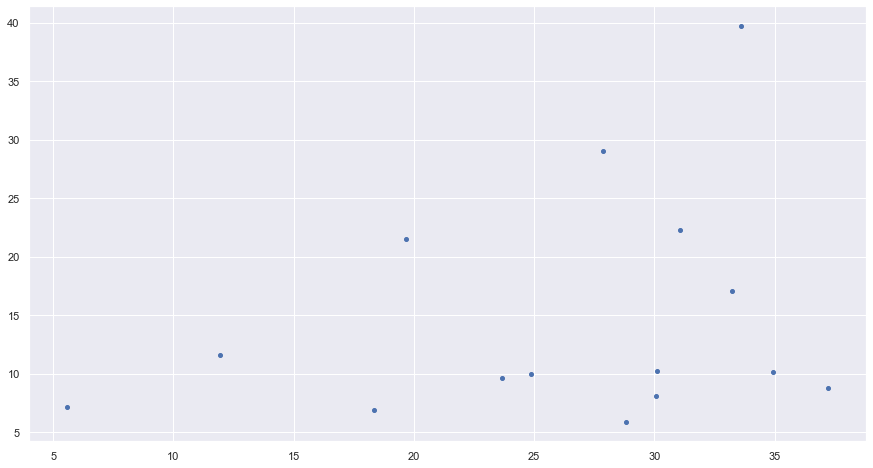

In [44]:
plt.plot(yearly_change_monetary_base_since_2003['Monetary Base'][1:],yearly_inflation_since_2003['Inflation'].values[1:-1],'o',markersize=4)

[Text(0, 0.5, 'Pearson coefficient'),
 Text(0.5, 0, 'lag in years'),
 Text(0.5, 1.0, 'Pearson coefficient shifting monetary base, since 2004')]

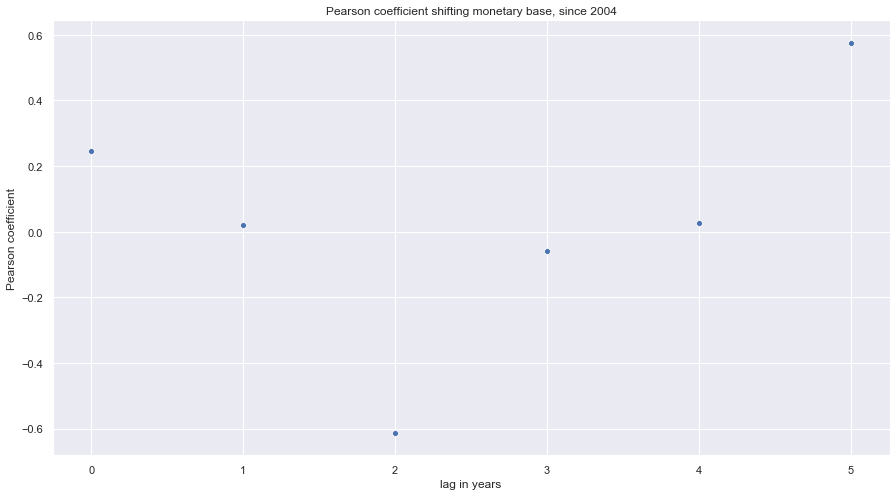

In [45]:
rs = [crosscorr(yearly_inflation_since_2003[:-1].reset_index().drop(['Dates'],axis=1),yearly_change_monetary_base_since_2003[1:].drop(['Dates'],axis=1), lag) for lag in np.arange(0,6,1)]
ax = sns.scatterplot(np.arange(0,6,1),rs)
ax.set(xlabel='lag in years', ylabel='Pearson coefficient',title='Pearson coefficient shifting monetary base, since 2004')

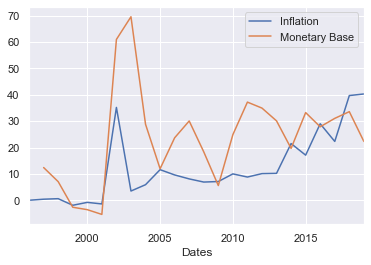

In [22]:
data_shifted=pd.DataFrame(yearly_inflation_since_1996['Inflation'])
data_shifted=data_shifted.merge(yearly_change_monetary_base["Monetary Base"].shift(0),on=data_shifted.index)
data_shifted=data_shifted.rename(columns={"key_0":"Dates"}).set_index('Dates')
data_shifted.dropna()

data_shifted.plot()

In [23]:
yearly_change_monetary_base

,Dates,Monetary Base
0,1996-12-31,NaN
1,1997-12-31,12.404216
2,1998-12-31,7.054448
3,1999-12-31,-2.647394
4,2000-12-31,-3.566412
5,2001-12-31,-5.368243
6,2002-12-31,60.979362
7,2003-12-31,69.581882
8,2004-12-31,28.824240
9,2005-12-31,11.933062


In [24]:
data_shifted1=pd.DataFrame(yearly_inflation_since_2003['Inflation'])
#data_shifted1=data_shifted1.merge(yearly_change_monetary_base_since_2003.reset_index().drop(['Dates','index'],axis=1).shift(0),on=data_shifted1.index)
